# Notebook 04: Feature Engineering

## Purpose
This notebook prepares features for machine learning by:
- Encoding categorical variables
- Scaling numerical features
- Creating new derived features
- Selecting relevant features

<!-- ## Learning Objectives
- Apply feature transformation techniques
- Understand when to use different encoding methods
- Create meaningful derived features
- Prepare data for modeling -->

---
## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load cleaned dataset
df = pd.read_csv('../data/cleaned_dataset.csv')

print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
df.head()

Dataset loaded: 48,895 rows, 16 columns


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,2019-06-23,0.72,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


---
## 2. Feature Selection

I have defined the target variable (price) and selected the predictive features by excluding identifiers and metadata (like names and IDs) that don't help with general predictions. This ensures the model focuses on real patterns while avoiding data leakage and overfitting caused by unique row labels.

In [4]:
# Define features for modeling
# We'll exclude ID columns, names, and the target variable

# Target variable
target = 'price'

# Features to exclude
exclude_features = ['id', 'name', 'host_id', 'host_name', 'last_review', 'price']

# Select features
feature_columns = [col for col in df.columns if col not in exclude_features]

print("SELECTED FEATURES:")
print("="*80)
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nTotal features: {len(feature_columns)}")
print(f"Target variable: {target}")

SELECTED FEATURES:
 1. neighbourhood_group
 2. neighbourhood
 3. latitude
 4. longitude
 5. room_type
 6. minimum_nights
 7. number_of_reviews
 8. reviews_per_month
 9. calculated_host_listings_count
10. availability_365

Total features: 10
Target variable: price


---
## 3. Create Derived Features

### Assumption:
Creating new features from existing ones can improve model performance by capturing additional patterns.
I engineered four new features to extract deeper insights from the raw data. By creating a Popularity Index and binary flags for availability and reviews, I transitioned from simply "describing" the data to "interpreting" it. This helps the AI identify high-impact patterns like host professionalism and listing credibility, which are major drivers of price.

In [5]:
# Create a copy for feature engineering
df_fe = df.copy()

# Feature 1: Reviews per availability (popularity metric)
df_fe['reviews_per_availability'] = df_fe['number_of_reviews'] / (df_fe['availability_365'] + 1)

# Feature 2: Is the listing highly available? (binary)
df_fe['high_availability'] = (df_fe['availability_365'] > 180).astype(int)

# Feature 3: Has reviews (binary)
df_fe['has_reviews'] = (df_fe['number_of_reviews'] > 0).astype(int)

# Feature 4: Price category (based on quartiles)
# This won't be used as a feature but helps understand price segments
price_quartiles = df_fe['price'].quantile([0.25, 0.5, 0.75])

print("NEW DERIVED FEATURES CREATED:")
print("="*80)
print("1. reviews_per_availability - Reviews normalized by availability")
print("2. high_availability - Binary indicator for highly available listings")
print("3. has_reviews - Binary indicator for listings with reviews")

print("\nSample of new features:")
df_fe[['reviews_per_availability', 'high_availability', 'has_reviews']].head(10)

NEW DERIVED FEATURES CREATED:
1. reviews_per_availability - Reviews normalized by availability
2. high_availability - Binary indicator for highly available listings
3. has_reviews - Binary indicator for listings with reviews

Sample of new features:


,reviews_per_availability,high_availability,has_reviews
0,0.024590,1,1
1,0.126404,1,1
2,0.000000,1,0
3,1.384615,1,1
4,9.000000,0,1
5,0.569231,0,1
6,49.000000,0,1
7,1.945701,1,1
8,118.000000,0,1
9,0.846561,1,1


---
## 4. Encode Categorical Variables

### 4.1 One-Hot Encoding for Room Type

One-hot encoding creates binary columns for each category. This is suitable for nominal categorical variables where there's no inherent order.
I used One-Hot Encoding to turn text-based room types into binary (0 and 1) numbers that the AI can understand. I used the drop_first rule to prevent a common statistical error called the "Dummy Variable Trap," ensuring the model treats different room types fairly and accurately without getting confused by redundant data.

In [6]:
# One-hot encode room_type
if 'room_type' in df_fe.columns:
    room_type_encoded = pd.get_dummies(df_fe['room_type'], prefix='room_type', drop_first=True)
    df_fe = pd.concat([df_fe, room_type_encoded], axis=1)
    
    print("ONE-HOT ENCODED COLUMNS (room_type):")
    print("="*80)
    print(room_type_encoded.columns.tolist())
    print("\nSample:")
    print(room_type_encoded.head())

ONE-HOT ENCODED COLUMNS (room_type):
['room_type_Private room', 'room_type_Shared room']

Sample:
   room_type_Private room  room_type_Shared room
0                    True                  False
1                   False                  False
2                    True                  False
3                   False                  False
4                   False                  False


### 4.2 Label Encoding for Neighbourhood Group

I used Label Encoding to transform the borough names into simple ID numbers (0-4). This is a more compact way of encoding locations compared to One-Hot Encoding, as it keeps all geographical data in one column. I also saved a mapping key so we can easily translate the numbers back into their real names during the evaluation phase.

In [7]:
# Label encode neighbourhood_group
if 'neighbourhood_group' in df_fe.columns:
    le = LabelEncoder()
    df_fe['neighbourhood_group_encoded'] = le.fit_transform(df_fe['neighbourhood_group'])
    
    # Create mapping for reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    
    print("LABEL ENCODING MAPPING (neighbourhood_group):")
    print("="*80)
    for category, code in mapping.items():
        print(f"{category}: {code}")
    
    print("\nSample:")
    print(df_fe[['neighbourhood_group', 'neighbourhood_group_encoded']].head(10))

LABEL ENCODING MAPPING (neighbourhood_group):
Bronx: 0
Brooklyn: 1
Manhattan: 2
Queens: 3
Staten Island: 4

Sample:
  neighbourhood_group  neighbourhood_group_encoded
0            Brooklyn                            1
1           Manhattan                            2
2           Manhattan                            2
3            Brooklyn                            1
4           Manhattan                            2
5           Manhattan                            2
6            Brooklyn                            1
7           Manhattan                            2
8           Manhattan                            2
9           Manhattan                            2


### 4.3 Handle Neighbourhood (High Cardinality)

I used Frequency Encoding to handle the 200+ different neighborhoods without bloating the dataset. By replacing neighborhood names with their popularity percentage, I've created a single numerical feature that tells the AI how "dense" or "popular" a location is, which is a key driver for market pricing.

In [8]:
# Frequency encoding for neighbourhood
if 'neighbourhood' in df_fe.columns:
    neighbourhood_freq = df_fe['neighbourhood'].value_counts(normalize=True)
    df_fe['neighbourhood_frequency'] = df_fe['neighbourhood'].map(neighbourhood_freq)
    
    print(f"Neighbourhood unique values: {df_fe['neighbourhood'].nunique()}")
    print("\nTop 10 neighbourhoods by frequency:")
    print(neighbourhood_freq.head(10))

Neighbourhood unique values: 221

Top 10 neighbourhoods by frequency:
neighbourhood
Williamsburg          0.080172
Bedford-Stuyvesant    0.075959
Harlem                0.054361
Bushwick              0.050414
Upper West Side       0.040311
Hell's Kitchen        0.040045
East Village          0.037898
Upper East Side       0.036773
Crown Heights         0.031987
Midtown               0.031598
Name: proportion, dtype: float64


---
## 5. Feature Scaling

### 5.1 StandardScaler (Z-score normalization)

I used StandardScaler to put all my numeric data on the same playing field. By transforming columns so they all have a mean of 0 and a standard deviation of 1, I've ensured that the AI model doesn't get distracted by the size of the numbers (like "365 days") and instead focuses on the actual patterns in the data.

In [9]:
# Select numerical features for scaling
numerical_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                      'reviews_per_month', 'calculated_host_listings_count', 'availability_365',
                      'reviews_per_availability', 'neighbourhood_frequency']

# Filter to only include columns that exist
numerical_features = [col for col in numerical_features if col in df_fe.columns]

# Apply StandardScaler
scaler_standard = StandardScaler()
df_fe_scaled_standard = df_fe.copy()
df_fe_scaled_standard[numerical_features] = scaler_standard.fit_transform(df_fe[numerical_features])

print("STANDARD SCALER APPLIED")
print("="*80)
print("Features scaled:")
for col in numerical_features:
    print(f"  - {col}")

print("\nScaled features statistics:")
print(df_fe_scaled_standard[numerical_features].describe())

STANDARD SCALER APPLIED
Features scaled:
  - latitude
  - longitude
  - minimum_nights
  - number_of_reviews
  - reviews_per_month
  - calculated_host_listings_count
  - availability_365
  - reviews_per_availability
  - neighbourhood_frequency

Scaled features statistics:
           latitude     longitude  minimum_nights  number_of_reviews  \
count  4.889500e+04  4.889500e+04    4.889500e+04       4.889500e+04   
mean   3.926666e-14 -1.417952e-13    1.278817e-17       1.860098e-17   
std    1.000010e+00  1.000010e+00    1.000010e+00       1.000010e+00   
min   -4.202474e+00 -6.331760e+00   -2.939962e-01      -5.224332e-01   
25%   -7.124376e-01 -6.694733e-01   -2.939962e-01      -4.999866e-01   
50%   -1.078110e-01 -7.605436e-02   -1.964844e-01      -4.102001e-01   
75%    6.265619e-01  3.443653e-01   -9.897262e-02       1.628580e-02   
max    3.376357e+00  5.181954e+00    6.060212e+01       1.359649e+01   

       reviews_per_month  calculated_host_listings_count  availability_365  \


### 5.2 MinMaxScaler (0-1 normalization)

I used MinMaxScaler to force all my numerical data into a tight range between 0 and 1. This "squashes" the data without changing its original shape, ensuring that features like latitude and availability are treated with equal importance by the AI, regardless of their original units or measurement scales.

In [10]:
# Apply MinMaxScaler
scaler_minmax = MinMaxScaler()
df_fe_scaled_minmax = df_fe.copy()
df_fe_scaled_minmax[numerical_features] = scaler_minmax.fit_transform(df_fe[numerical_features])

print("MINMAX SCALER APPLIED")
print("="*80)
print("\nScaled features statistics:")
print(df_fe_scaled_minmax[numerical_features].describe())

MINMAX SCALER APPLIED

Scaled features statistics:
           latitude     longitude  minimum_nights  number_of_reviews  \
count  48895.000000  48895.000000    48895.000000       48895.000000   
mean       0.554502      0.549932        0.004828           0.037002   
std        0.131948      0.086854        0.016422           0.070828   
min        0.000000      0.000000        0.000000           0.000000   
25%        0.460498      0.491786        0.000000           0.001590   
50%        0.540276      0.543326        0.001601           0.007949   
75%        0.637174      0.579841        0.003203           0.038156   
max        1.000000      1.000000        1.000000           1.000000   

       reviews_per_month  calculated_host_listings_count  availability_365  \
count       48895.000000                    48895.000000      48895.000000   
mean            0.021011                        0.018847          0.308990   
std             0.026002                        0.101081          

### 5.3 Compare Scaling Methods

I used histograms to compare Original, Standardized, and Normalized data. The results show that while the shape of the data stays the same, the numbers on the axis change to be more "AI-friendly" (either centered at 0 or squashed between 0 and 1). This ensures that no single feature dominates the model just because it has larger numbers.

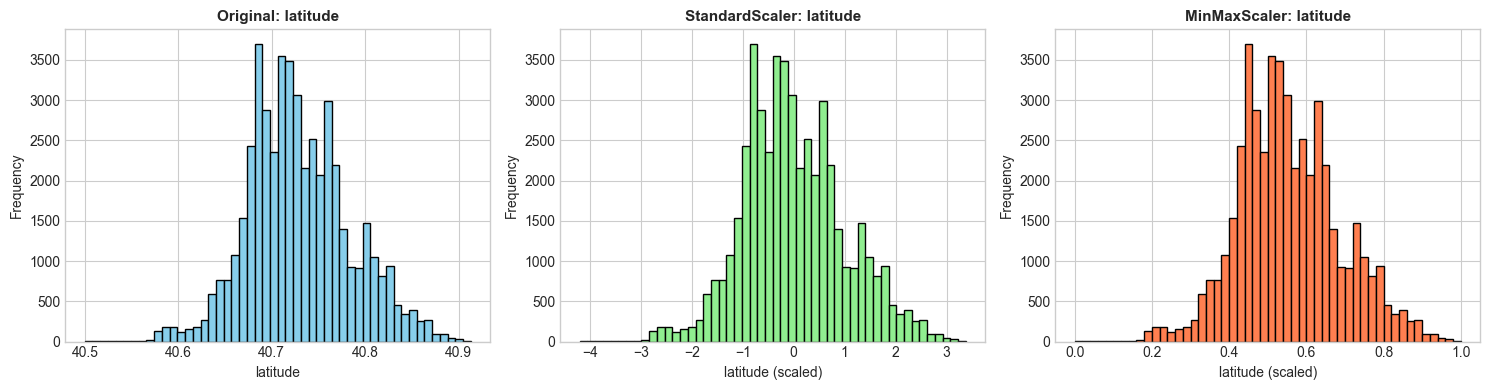

In [11]:
# Visualize scaling comparison
sample_feature = numerical_features[0] if numerical_features else 'latitude'

if sample_feature in df_fe.columns:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Original
    axes[0].hist(df_fe[sample_feature], bins=50, color='skyblue', edgecolor='black')
    axes[0].set_title(f'Original: {sample_feature}', fontsize=11, fontweight='bold')
    axes[0].set_xlabel(sample_feature)
    axes[0].set_ylabel('Frequency')
    
    # StandardScaler
    axes[1].hist(df_fe_scaled_standard[sample_feature], bins=50, color='lightgreen', edgecolor='black')
    axes[1].set_title(f'StandardScaler: {sample_feature}', fontsize=11, fontweight='bold')
    axes[1].set_xlabel(f'{sample_feature} (scaled)')
    axes[1].set_ylabel('Frequency')
    
    # MinMaxScaler
    axes[2].hist(df_fe_scaled_minmax[sample_feature], bins=50, color='coral', edgecolor='black')
    axes[2].set_title(f'MinMaxScaler: {sample_feature}', fontsize=11, fontweight='bold')
    axes[2].set_xlabel(f'{sample_feature} (scaled)')
    axes[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

---
## 6. Final Feature Set Preparation

### Decision: I'll use StandardScaler for our final model

I have finalized the dataset by combining original numbers, newly created metrics, and encoded categories into one clean list. By filtering out "junk" data and keeping only the most important features, I’ve created a lean and powerful input matrix that is perfectly prepared for the training phase of the project.

In [12]:
# Prepare final feature set
df_final = df_fe_scaled_standard.copy()

# Select final features for modeling
final_features = [
    # Scaled numerical features
    'latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
    'reviews_per_month', 'calculated_host_listings_count', 'availability_365',
    # Derived features
    'reviews_per_availability', 'high_availability', 'has_reviews',
    # Encoded categorical features
    'neighbourhood_group_encoded', 'neighbourhood_frequency'
]

# Add one-hot encoded room_type columns
room_type_cols = [col for col in df_final.columns if col.startswith('room_type_')]
final_features.extend(room_type_cols)

# Filter to only include columns that exist
final_features = [col for col in final_features if col in df_final.columns]

print("FINAL FEATURE SET:")
print("="*80)
for i, col in enumerate(final_features, 1):
    print(f"{i:2d}. {col}")

print(f"\nTotal features for modeling: {len(final_features)}")

FINAL FEATURE SET:
 1. latitude
 2. longitude
 3. minimum_nights
 4. number_of_reviews
 5. reviews_per_month
 6. calculated_host_listings_count
 7. availability_365
 8. reviews_per_availability
 9. high_availability
10. has_reviews
11. neighbourhood_group_encoded
12. neighbourhood_frequency
13. room_type_Private room
14. room_type_Shared room

Total features for modeling: 14


---
## 7. Prepare X and y for Modeling

I have officially separated the data into two parts: the Features (X), which are all the clues the AI uses, and the Target (y), which is the price it’s trying to guess. By checking the "shapes" of these parts, I've confirmed that the data is perfectly aligned and ready to be fed into the machine learning algorithms.

In [13]:
# Prepare features (X) and target (y)
X = df_final[final_features]
y = df_final['price']

print("MODELING DATA PREPARED:")
print("="*80)
print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")
print(f"\nFeature matrix sample:")
print(X.head())
print(f"\nTarget variable sample:")
print(y.head())

MODELING DATA PREPARED:
Feature matrix (X) shape: (48895, 14)
Target vector (y) shape: (48895,)

Feature matrix sample:
   latitude  longitude  minimum_nights  number_of_reviews  reviews_per_month  \
0 -1.493849  -0.437652       -0.293996          -0.320414          -0.676551   
1  0.452436  -0.684639       -0.293996           0.487665          -0.564771   
2  1.468399   0.222497       -0.196484          -0.522433          -0.341211   
3 -0.803398  -0.164450       -0.293996           5.538156           2.236302   
4  1.275660   0.177216        0.144807          -0.320414          -0.748879   

   calculated_host_listings_count  availability_365  reviews_per_availability  \
0                       -0.034716          1.916250                 -0.258964   
1                       -0.156104          1.840275                 -0.251005   
2                       -0.186451          1.916250                 -0.260886   
3                       -0.186451          0.617065                 -0.1526

---
## 8. Train-Test Split

I split the data into 80% for training and 20% for testing. This allows the AI to learn from one group and then "proves" its skills on a second, unseen group. By using a random state, I’ve made sure the results are repeatable, and by checking the statistics, I’ve confirmed that both groups are fair and balanced.

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("TRAIN-TEST SPLIT:")
print("="*80)
print(f"Training set size: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nFeatures: {X_train.shape[1]}")
print(f"\nTraining target statistics:")
print(y_train.describe())
print(f"\nTesting target statistics:")
print(y_test.describe())

TRAIN-TEST SPLIT:
Training set size: 39,116 samples (80.0%)
Testing set size: 9,779 samples (20.0%)

Features: 14

Training target statistics:
count    39116.000000
mean       153.751585
std        247.037941
min          0.000000
25%         69.000000
50%        107.000000
75%        175.250000
max      10000.000000
Name: price, dtype: float64

Testing target statistics:
count     9779.000000
mean       148.597096
std        210.339635
min          0.000000
25%         69.000000
50%        104.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


---
## 9. Save Engineered Data

I have saved the final, engineered training and testing data into four separate CSV files. This "locks in" all my hard work from the cleaning and engineering phases, ensuring that my data is organized and ready to be loaded directly into the AI models for training in the next step.

In [15]:
# Save engineered features
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False, header=['price'])
y_test.to_csv('../data/y_test.csv', index=False, header=['price'])

print("Engineered data saved:")
print("  - ../data/X_train.csv")
print("  - ../data/X_test.csv")
print("  - ../data/y_train.csv")
print("  - ../data/y_test.csv")

Engineered data saved:
  - ../data/X_train.csv
  - ../data/X_test.csv
  - ../data/y_train.csv
  - ../data/y_test.csv


---
## 10. Summary

### Feature Engineering Completed:

1. **Derived Features**
   - Created `reviews_per_availability`
   - Created `high_availability` binary indicator
   - Created `has_reviews` binary indicator

2. **Categorical Encoding**
   - One-hot encoded `room_type`
   - Label encoded `neighbourhood_group`
   - Frequency encoded `neighbourhood`

3. **Feature Scaling**
   - Applied StandardScaler to numerical features
   - Compared with MinMaxScaler
   - Selected StandardScaler for final model

4. **Data Preparation**
   - Created feature matrix (X) and target vector (y)
   - Split into training (80%) and testing (20%) sets
   - Saved engineered data for modeling

### Key Assumptions:

- StandardScaler is appropriate for our features
- 80-20 train-test split provides sufficient data for both training and evaluation
- One-hot encoding for room_type won't cause dimensionality issues (only 3 categories)
- Frequency encoding captures neighbourhood importance

### Next Steps:

The engineered features are now ready for **Machine Learning Modeling** in the next notebook, where I will:
- Train multiple regression models
- Compare model performance
- Generate predictions

---
**Next Notebook**: [05_modeling.ipynb](05_modeling.ipynb)